<a href="https://colab.research.google.com/github/sohailahazem/facial_recognition/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Import Data

In [ ]:
# drive.mount('/content/drive')
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/faces_dataset" "/content/faces_dataset"
faces_path = '/content/drive/MyDrive/faces_dataset'

Mounted at /gdrive


In [ ]:
datamatrix=[]
for i in range(1,41):
  for j in range(1,11):
    image = Image.open(f"{faces_path}/s{i}/{j}.pgm")
    matrix = np.asarray(image).flatten()
    datamatrix.append(matrix)
datamatrix = np.array(datamatrix)    



## Labels vector coresponding to subject

In [ ]:
labels=[]
for i in range(1,41):
  for j in range(1,11):
    labels.append(i)
# print(labels)
row, col = datamatrix.shape
#labels =np.array([labels]).T #idek if this is right but i did 3ashan kol row fel data matrix yeb2a labeled? 

## Split Dataset into training and test sets: (odd rows for training and even for tests) 

In [ ]:
train_data =[]
test_data =[]
train_labels=[]
test_labels = []

for i in range(0,row):
  if i %2 == 0:
    test_data.append((datamatrix[i]))
    test_labels.append((labels[i]))
  else: 
    train_data.append((datamatrix[i]))
    train_labels.append((labels[i]))

train_data =np.array(train_data)
test_data =np.array(test_data)
train_labels=np.array(train_labels)
test_labels =np.array(test_labels)
# print(test_data)
# print(test_data)
ro, col = test_data.shape
print(col)

10304


## Computing PCA:

### mean, covariance 

In [ ]:
Mean=np.mean(train_data,axis=0)
centered_D= train_data-Mean 
covariance = np.cov(centered_D,rowvar=False, bias = True)
eigen_values,eigen_vectors = np.linalg.eigh(covariance)
print(eigen_values)
print(eigen_vectors)

[-1.80602641e-09 -1.25477121e-09 -9.60870365e-10 ...  1.06569341e+06
  2.14179597e+06  2.76884465e+06]
[[ 0.          0.          0.         ... -0.01891079 -0.01536171
   0.00124556]
 [ 0.47921373 -0.16848932 -0.10885945 ... -0.01911777 -0.01513146
   0.00126454]
 [-0.45822015 -0.23577699 -0.06253177 ... -0.01903942 -0.01516195
   0.00156465]
 ...
 [-0.00100661  0.00872914  0.03050388 ... -0.01287451  0.00961112
   0.00873725]
 [ 0.01404303  0.01066199 -0.0072786  ... -0.01377318  0.0077597
   0.00721705]
 [-0.00344785 -0.02715983  0.01509779 ... -0.01438815  0.00692708
   0.0084008 ]]


In [ ]:
# print (np.dot(np.dot(eigen_vectors,np.diag(eigen_values)),np.transpose(eigen_vectors)))
# print(covariance)
# print("\n eigen value  matrix\n", eigen_values.shape)
# print("\n eigen vectors  matrix\n", eigen_vectors.shape)

### Fraction of the total variance function

In [ ]:
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalue = eigen_values[sorted_index]
sorted_eigenvectors = eigen_vectors[:,sorted_index]
alphas = [0.8, 0.85, 0.9, 0.95]
def f(eigen_values):
  chosen_r = [0, 0, 0, 0]
  chosen_eigen_sum = 0
  index = 0
  r = 0
  eigen_sum = sorted_eigenvalue.sum()
  for x in sorted_eigenvalue:
        chosen_eigen_sum += x
        if chosen_eigen_sum / eigen_sum >= alphas[index]:
          chosen_r[index] += r
          index+=1
          if index == 4:
            break
        r+=1 
  return chosen_r
chosen_r = f(sorted_eigenvalue)
print(chosen_r)

[36, 52, 76, 115]


### Projection Matrix and projecting the test and training data


In [ ]:
# for i in range(0,4):
#   P=sorted_eigenvectors[:chosen_r[i]]
# print(P)
# P = P[::-1] ## msh 3arfa a sort aka reverse wala la2 ?? 
# print(P)
# A_train = np.dot(train_data, np.transpose(P))
# A_test = np.dot(test_data, np.transpose(P))


[[ 0.00124556 -0.01536171 -0.01891079 ...  0.          0.
   0.        ]
 [ 0.00126454 -0.01513146 -0.01911777 ... -0.10885945 -0.16848932
   0.47921373]
 [ 0.00156465 -0.01516195 -0.01903942 ... -0.06253177 -0.23577699
  -0.45822015]
 ...
 [-0.00668345 -0.01327393 -0.0186983  ... -0.00179215 -0.00126579
  -0.00566763]
 [-0.007396   -0.01330963 -0.01926375 ... -0.00092875  0.00820206
  -0.00437651]
 [-0.00829428 -0.01247457 -0.01861699 ... -0.00163733 -0.00659515
   0.00066764]]
[[-0.00829428 -0.01247457 -0.01861699 ... -0.00163733 -0.00659515
   0.00066764]
 [-0.007396   -0.01330963 -0.01926375 ... -0.00092875  0.00820206
  -0.00437651]
 [-0.00668345 -0.01327393 -0.0186983  ... -0.00179215 -0.00126579
  -0.00566763]
 ...
 [ 0.00156465 -0.01516195 -0.01903942 ... -0.06253177 -0.23577699
  -0.45822015]
 [ 0.00126454 -0.01513146 -0.01911777 ... -0.10885945 -0.16848932
   0.47921373]
 [ 0.00124556 -0.01536171 -0.01891079 ...  0.          0.
   0.        ]]


### KNN

In [ ]:
def KNN(X_train,X_test,y_train,y_test,k):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  labels_pred = knn.predict(X_test)
  accuracy = accuracy_score(y_test,labels_pred)
  return accuracy 


### Accuracy for every value of alpha

Accuracy of alpha = 0.8 with k = 1 is 0.725
Accuracy of alpha = 0.8 with k = 3 is 0.655
Accuracy of alpha = 0.8 with k = 5 is 0.62
Accuracy of alpha = 0.8 with k = 7 is 0.575


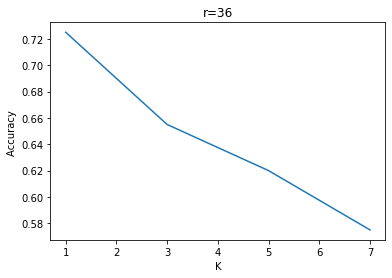

Accuracy of alpha = 0.85 with k = 1 is 0.815
Accuracy of alpha = 0.85 with k = 3 is 0.72
Accuracy of alpha = 0.85 with k = 5 is 0.675
Accuracy of alpha = 0.85 with k = 7 is 0.64


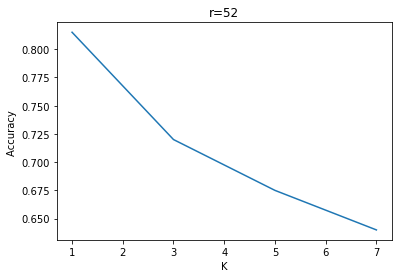

Accuracy of alpha = 0.9 with k = 1 is 0.865
Accuracy of alpha = 0.9 with k = 3 is 0.77
Accuracy of alpha = 0.9 with k = 5 is 0.715
Accuracy of alpha = 0.9 with k = 7 is 0.725


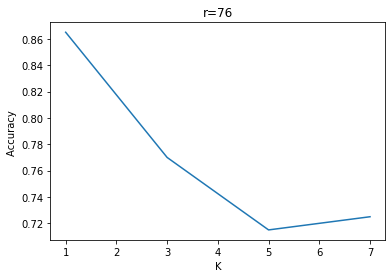

Accuracy of alpha = 0.95 with k = 1 is 0.91
Accuracy of alpha = 0.95 with k = 3 is 0.82
Accuracy of alpha = 0.95 with k = 5 is 0.775
Accuracy of alpha = 0.95 with k = 7 is 0.74


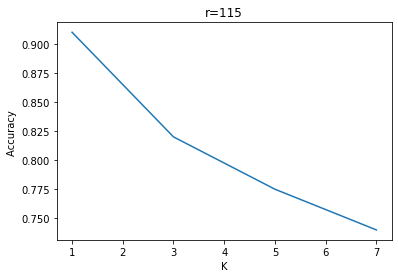

In [ ]:
k_neighbors = [1,3,5,7] # chose 4 bc alphas are 4? im not sure and odd because i read they give better accuracies ? 
for i in range(0,4):
  P=sorted_eigenvectors[:chosen_r[i]]
  P = P[::-1]
  A_train = np.dot(train_data, np.transpose(P))
  A_test = np.dot(test_data, np.transpose(P))
  accuracies =[]
  for k in k_neighbors: 
    accuracy = KNN(A_train,A_test,train_labels,test_labels,k)
    accuracies.append(accuracy)
    print(f"Accuracy of alpha = {alphas[i]} with k = {k} is {accuracy}")  
  plt.title(f'r={chosen_r[i]}')
  plt.xlabel('K')
  plt.ylabel('Accuracy ')
  plt.plot(k_neighbors,accuracies)
  plt.show()


